# Task 2

From the coursework document:

The second task is about classifying handwritten digits. We will use the MNIST dataset for training and testing. The point of this task is to develop a multi-layer neural network for classification using mostly Numpy:
* Implement sigmoid and relu layers (with forward and backward pass) 
* Implement a softmax output layer 
* Implement a fully parameterizable neural network (number and types of layers, number  of units) 
* Implement an optimizer (e.g. SGD or Adam) and a stopping criterion of your choosing 
* Train your Neural Network using backpropagation.

Evaluate different neural network architectures and compare your different results.


## External Sources Used

- Pytorch documnetation: https://pytorch.org/docs/stable/torchvision/datasets.html#mnist and https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html About 8 lines of code were taken from the latter for the purposes of downloading and displaying samples from MNIST.
- (No code was taken) Andrew Ng's (and Standford University) Machine Learning course. Professor Ng's conventions were used for building the neural network. https://www.youtube.com/playlist?list=PLLssT5z_DsK-h9vYZkQkYNWcItqhlRJLN
- (No code was taken) Rakshith Vasudev article on how to initialze the values for the weight matrices using Xavier's Random Distribution. https://medium.com/hackernoon/how-to-initialize-weights-in-a-neural-net-so-it-performs-well-3e9302d4490f
- mdml's answer on a StackOverflow question by NLi10Me, on how to replace elements in a multidimensional numpy array by value without looping. https://stackoverflow.com/questions/19666626/replace-all-elements-of-python-numpy-array-that-are-greater-than-some-value 1 line of code was used and appropriated for the purposes of the relu activation function.

### Loading the Data Set

We will use Pytorch's torchvision module to load the MNIST dataset.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import util

In [2]:
# Downloading MNIST
transform = transforms.Compose(
    [transforms.ToTensor()])

#Transet is the entire train set... each item is a 2-tuple, containing an tensor (numeric rep of image) and the target value (int)
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

## Exploring the Data set

Each of trainset and testset are objects of type MNIST. This is a collection of Tuples. Every tuple is comprised of a Tensor, and an integer. The Tensor is a three dimensional matrix, of shape 1 x 28 x 28. The integer is the target value (e.g. if the Tensor is an image displaying a handwritten "2", the corresponding integer will be 2)

We code a display_image, which makes use of plt.imshow to select a tensor in a given set, and plot it below.


Size of Train set is 60000
Size of Test set is 10000

Image depicts the target: 2


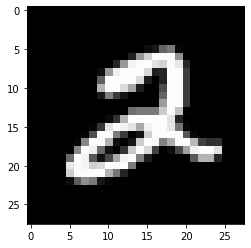

In [3]:
def display_image(image_pos=0, set=trainset):
    # First image's tensor accessed by set[0][0], its shape is 1, 28, 28
    # Notice set[0][1] is the target class of that image.. in this case, 5
    print(f"Image depicts the target: {set[image_pos][1]}")
    imgplot = plt.imshow(set[image_pos][0].numpy().reshape((28, 28)), cmap='gray')


print(f"\nSize of Train set is {len(trainset)}")
print(f"Size of Test set is {len(testset)}\n")

display_image(image_pos=5, set=trainset)


## Numpy Neural Network

We build three components for the functioning of our numpy neural network:
- the Layer class (see below)
- the util.py library (found in src/util.py, go to ReadMe for details)
- the NN class (see below)

### The Layer Class

The Layer class defines the layers of the Neural Network. It was not designed to be instantiated directly, but rather, to be used internally by the NN class. A user will call an NN object's "add_layer" method, passing the number of nodes, and the name of an activation function ("sigmoid", "relu" or "softmax"), this will create a Layer, and store it inside the NN object. More on the relationship between the classes Layer and NN on our discussion of NN below.

Each layer, as defined by the Layer class takes in:
- the nodes of the previous layer (this is passed in automatically by the NN class)
- the nodes of the current layer
- the activation function
- the batch size (this is defined by the user when instantiating the NN, and passed automatically by the NN to every layer created for it)

These parameters are then used to define various matrices used for forward and backward propagation. Including:
- The weights assoicated with the layer. These are the weights being passed into that layer from the previous one. Since we are following Andrew Ng's conventions, the input matrix is defined with the rows representing features, and the columns representing samples. Hence, weight matrices will have dimensions "nodes of current layer x nodes of previous layer".
- The biases, dimensions  "nodes of current layer x 1"
- The "z". Using Andrew Ng's conventions, this is the input of the layer before activation.
- The "a". Using Andrew Ng's conventions, this is simply the ouput of the layer's activation function, with "z" as the input.
- The $\delta$. Using Andrew Ng's convention, this is the matrix representing the contribution of the current layer to the ouput layer's error. It will therefore have dimensions equal to the dimensions of the current layer.
- The $\Delta$. Using Andrew Ng's conventions, this is an accumulator which incrementally updates with every backward pass. This will be multiplied by the learning rate to update the weights matrix during gradient descent. Its dimensions are therefore equal to the weights matrix.

The Layer class also holds utility methods that will be used during forward propagation, and backward propagation, depending on the activation function defined for that layer.
- "activate" function: this calculates matrix "a", by passing "z" through the activation function.
- "derive" function; this takes an "X" and returns the value of passing this "X" into the derivative of the layer's activation function.

In [4]:
class Layer():
    def __init__(self, nodes_of_prev, nodes=784, activation="sigmoid", batch_size=1):
        self.nodes = nodes
        self.activation = activation
        self.nodes_of_prev = nodes_of_prev
        self.batch_size = batch_size
        #Additionally, each layer has:
        # - the weights going into it (nodes x nodes_of_prev)
        # - the biases of the layer (nodes x 1)
        # - z matrix, the dot product between the previous layer and the weights of this layer (nodes x batch_size)
        # - a matrix, the result of passing z into the activation function (nodes x batch_size)
        # - d matrix (nodes x batch_size)
        # - delta_accumulator matrix, (nodes x nodes_of_prev)
        self.weights = np.random.randn(self.nodes, self.nodes_of_prev) * np.sqrt(2/self.nodes)
        self.b = np.random.randn(self.nodes, 1) * np.sqrt(2/self.nodes)
        self.z = np.random.rand(self.nodes, self.batch_size)
        self.a = np.random.rand(self.nodes, self.batch_size)
        self.d = np.zeros(self.a.shape)
        self.delta_accumulator = np.zeros(self.weights.shape)
    
    def activate(self):
        if(self.activation == "sigmoid"):
            self.a = self.sigmoid(X=self.z)
        if(self.activation == "relu"):
            self.a = self.relu(X=self.z)
        if(self.activation == "softmax"):
            self.a = self.softmax(X=self.z)
    
    def derive(self, X):
        if(self.activation == "sigmoid"):
            return (self.sigmoid(X=X, diff=True))
        if(self.activation == "relu"):
            return (self.relu(X=X, diff=True))
        if(self.activation == "softmax"):
            return (self.softmax(X=X, diff=True))
    
    def sigmoid(self, X, diff=False):
        sigmoid_original = 1 / (1 + np.e**(-X))
        if (not diff):
            return sigmoid_original
        else:
            return sigmoid_original * (1 - sigmoid_original)
    
    def relu(self, X, diff=False):
        if(not diff):
            #Reference for replacing each value in np array:
            #https://stackoverflow.com/questions/19666626/replace-all-elements-of-python-numpy-array-that-are-greater-than-some-value
            X[X<=0] = 0
            return X
        else:
            X[X<=0] = 0
            X[X>0] = 1
            return X

    def softmax(self, X, diff=False):
        if (not diff):
            return (np.e ** X) / sum(np.e ** X)
        else:
            return (np.e ** X) / sum((np.e ** X)) * (1 - (np.e ** X) / sum((np.e ** X)))


### The NN class

The NN class defines our numpy neural network. This takes in the training set (X and y), learning rate, regularization parameter, and the batch size. When instantiating the NN, the user may also: 
- enable early_stopping, which will end training once loss begins to diverge. Set to False (default) to disable.
- set lr_scaling. This is supposed to be small number, between 0 and 1. When loss begins to diverge, the learning rate will be scaled down using this value. Set lr_scaling to 0 (default) to disable it.
- set min_lr. This is optionally used in conjunction with lr_scaling. Determines a hard minimum for the learning rate. Set to 0 (default) to disable.

After instantiating the NN, you want to add layers to it using the add_layer method. Call your NN's add_layer method, passing in the number of nodes you wish to assign to that layer, and the name of the activation function ("sigmoid", "relu", "softmax").

The input layer is defined automatically, so you do not need to add it. You should add atleast one hidden layer (of whatever dimensions you wish), and one output layer (of dimensions equal to the number of target classes). 

Layers are sorted in an array, in the order they are added. Thus, the output layer should be the last to be added to the NN. We reccomend instantiating the NN, and adding all the layers, in the same Jupyter Notebook cell.

After building the NN (instantiating the NN, and adding the layers), you can call the fit method on your NN object. This will train the NN using the features and target you passed into the NN when instantiating. You need to pass in the number of epochs you wish the NN to train for. We reccomend doing so in a sparate Jupyter Notebook cell, to the one used to build the NN (this may allow you to continue training for more epochs afterwards).

CAUTION: since we are using Andrew Ng's conventions, the X and y should be passed with samples as columns, NOT with samples as rows. The "preprocess" function in the util.py library, will do this automatically for you.

When fitting, you may also optionally pass a "calc_accuracy" parameter into the fit method. This is a dictionary of shape {"X_test": np.array, "y_test": np.array}. Add the X and y of your testing dataset into this dictionary, and the NN will calculate your model's accuracy on the testing set after every epoch.

During trainig, the model will print out its progress for the epoch (asterisks proportional to the number of batches completed per epoch), the loss of the model, and (if "calc_accuracy" was passed into the fit method) the accuracy of the model on the testing set.

You can evaluate model performance using the "score" method, which takes in the X_test and y_test, and prints out the models accuracy. You may also wish to plot the loss over the number of epochs using the "plot_loss" method. Or plot accuracy over the number of epochs (if "calc_accuracy" was pased when fitting) using "plot_accuracy".




In [5]:
class NN():
    def __init__(self, X, y, lr=0.001, reg_param=1, batch_size=0, early_stopping=False, lr_scaling=0, min_lr=0):
        self.X = X
        self.y = y
        self.n = self.X.shape[0] #Number of features (rows as features)
        self.m = self.X.shape[1] #Number of data points (samples as columns)
        self.layers = []
        self.loss_history = []
        self.accuracy_history = []
        self.a0 = None
        self.hx = None
        self.lr = lr
        self.reg_param = reg_param
        self.early_stopping = early_stopping
        self.lr_scaling = lr_scaling
        self.min_lr = min_lr
        self.batch_size = batch_size
        if self.batch_size <= 0:
            self.batch_size = self.m
    
    def add_layer(self, nodes=784, activation="sigmoid"):
        number_of_layers = len(self.layers)
        #If the layers array is empty, the layer to be added will have its nodes_of_prev equal n
        if number_of_layers == 0:
            layer_to_add = Layer(nodes_of_prev=self.n, nodes=nodes, activation=activation, batch_size=self.batch_size)
            self.layers.append(layer_to_add)
        #Else, the layer to be added will have its nodes_of_prev equal the nodes of the previous layer in self.layers
        else:
            prev_layer = self.layers[number_of_layers - 1]
            layer_to_add = Layer(nodes_of_prev=prev_layer.nodes, nodes=nodes, activation=activation, batch_size=self.batch_size)
            self.layers.append(layer_to_add)
    
    def forward_pass(self, X, test_batch_size=0):
        #Set the dimensions of each layer to test_batch_size if testing
        if test_batch_size > 0:
            for i in range(len(self.layers)):
                self.layers[i].batch_size = test_batch_size
        #Take batch X forward, accross layers
        for i in range(len(self.layers)):
            layer = self.layers[i]
            if i == 0:
                self.a0 = X
                layer.z = layer.weights.dot(self.a0) + layer.b
                layer.activate()
            else:
                prev_layer = self.layers[i - 1]
                layer.z = layer.weights.dot(prev_layer.a) + layer.b
                layer.activate()
                if i == (len(self.layers) - 1):
                    self.hx = layer.a
    
    def backward_pass(self, X, y):
        last_layer_index = len(self.layers) - 1
        #Starting from last layer, calculate all delta terms
        i = last_layer_index
        while i >= 0:
            layer = self.layers[i]
            #If this is the last layer
            if (i == last_layer_index):
                layer.d = self.hx - y
            else:
                next_layer = self.layers[i + 1]
                layer.d = (next_layer.weights.transpose().dot(next_layer.d)) * layer.derive(layer.z)
            #Decrement
            i -= 1
        #Starting from first layer, calcualte delta accumulators and update all weights accordingly
        for i in range(len(self.layers)):
            layer = self.layers[i]
            if (i == 0):
                self.a0 = X
                layer.delta_accumulator += layer.d.dot(self.a0.transpose())
                gradients = layer.delta_accumulator * (self.reg_param/self.m)
                layer.weights -= gradients * self.lr
            else:
                prev_layer = self.layers[i - 1]
                layer.delta_accumulator += layer.d.dot(prev_layer.a.transpose())
                gradients = layer.delta_accumulator * (self.reg_param/self.m)
                layer.weights -= gradients * self.lr

    def fit(self, epochs, calc_accuracy=None, loss_precision=7):
        number_of_batches = int(self.m / self.batch_size)
        loss = 0
        for e in range(epochs):
            print(f"Starting epoch {e + 1}/{epochs}. ", end="")
            print("Processing: ", end="")
            for b in range(number_of_batches):
                if(number_of_batches%(b+1) == 0):
                    print(f"*", end="")
                start = b * self.batch_size
                end = (b + 1) * self.batch_size
                Xi = self.X[:, start:end]
                yi = self.y[:, start:end]
                self.forward_pass(Xi)
                self.backward_pass(Xi, yi)
            loss = self.calc_loss(self.hx, yi)
            print(f"\nLoss is {np.around(loss, loss_precision)}. ", end="")
            if not calc_accuracy == None:
                X_test = calc_accuracy["X_test"]
                y_test = calc_accuracy["y_test"]
                accuracy = self.score(X_test, y_test)
                print(f"Accuracy is {accuracy}")
                self.accuracy_history.append(accuracy)
            print(f"\n")
            self.loss_history.append(loss)
            if (e > 0 and (self.early_stopping or self.lr_scaling > 0)):
                #If current loss is less than previous one...
                if loss > self.loss_history[e - 1]:
                    #If lr scaling is set...
                    if(self.lr_scaling > 0):
                        print(f"Beginning to diverge... scaling learning rate by from {self.lr}, by {self.lr_scaling}, to {self.lr * self.lr_scaling}")
                        #If a minimum lr is set
                        if self.min_lr > 0:
                            self.lr = max((self.lr_scaling * self.lr), self.min_lr)
                        else:
                            self.lr *= self.lr_scaling
                    #If early stopping is set
                    if(self.early_stopping):
                        if(self.lr_scaling <= 0 or self.lr == self.min_lr):
                            print(f"Beginning to diverge... stopping early on epoch {e}")
                            break

    def calc_loss(self, hx, y):
        loss = (sum(sum((y * np.log(hx)) + ((1 - y) * np.log(1 - hx)))) / self.m) * -1
        return loss
    
    def plot_loss(self, ymin=None, ymax=None):
        history = self.loss_history
        if ymin == None:
            plt.ylim((min(history)), (max(history)))
        else:
            plt.ylim(ymin, ymax)
        plt.title("Loss Over Epochs")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.plot(list(range(len(history))), history)
        plt.show()
    
    def plot_accuracy(self, ymin=None, ymax=None):
        history = self.accuracy_history
        if len(history) == 0:
            print("Accuracy was not Recorded")
            return
        if ymin == None:
            plt.ylim((min(history)), (max(history)))
        else:
            plt.ylim(ymin, ymax)
        plt.title("Accuracy Over Epochs")
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        plt.plot(list(range(len(history))), history)
        plt.show()
    
    def score(self, X_test, y_test):
        predictions = self.predict(X_test)
        correct_answers = 0
        total_tests = len(predictions[0])
        for i in range(total_tests):
            prediction = util.decode(util.encode_probabilities(predictions[:, i]))
            correct = util.decode(y_test[:, i])
            if prediction == correct:
                correct_answers += 1
        accuracy = correct_answers / total_tests
        return accuracy
    
    def predict(self, X_test):
        test_batch_size = len(X_test)
        self.forward_pass(X_test, test_batch_size=test_batch_size)
        return self.hx


## Tutorial Building and Training our Numpy Neural Network

Below is a brief tutorial on how to use the aformentioned classes.

### Step 1

Preprocess the trainset and testset. We use util.preprocess, which takes in the .data and .targets of each of the two sets, and returns preprocessed versions for training and testing. 

The util.preprocess function:
- one hot encodes the target integers
- converts the features and targets into numpy arrays
- transposes them so that samples are columns, and features are rows (contrary to the default layout used by Pytorch)



In [6]:
#Split trainset and testset into features and target
features, target = util.preprocess(X=trainset.data, y=trainset.targets)
X_test, y_test = util.preprocess(X=testset.data, y=testset.targets)

You may optionally reduce the size of the training set by slicing it using the util.shorten method. Pass in the preprocessed features and target arrays, a start index, and an end index.

This is useful for checking the functioning of the Neural Network without spending a long time training on the full MNIST dataset (with 60,000 samples for training)!

In [7]:
#Shorten the dataset (optional! Just to check that the NN is working)
features_short, target_short = util.shorten(features, target, start=0, end=512)

### Step 2

Build the Neural Network. We instantiate the NN class by passing in the training features and target, a learning rate, a regularization parameter, and a batch size to use mini-batch gradient descent. To use stochastic gradient descent, you can set batch size to 1.

CAUTION: ensure that your batch size is smaller than or equal to the size of your training set!

We also enable lr_scaling by changing the default value of 0, to 0.8. This means our learning rate will scale down by 20% every time loss starts to diverge.

Next, we add layers to our neural network. The input layer is added automatically by the NN class. So we add four layers:
- A 100 node hidden layer, using sigmoid for activation
- A 60 node hidden layer, using relu for activation
- A 50 node hidden layer, using sigmoid for activation
- A 10 node output layer, using softmax for activation

CAUTION: ensure that the network has at least one hidden layer, that the ouput layer is the last to be added, and that the output layer has number of nodes, equal to the number of target classes. In the case of MNIST, since we have 10 classes, the target layer must have 10 nodes.

CAUTION: using relu activation for the last hidden layer, before the softmax output, may produce errors if learning rate is too high.



In [8]:
nn = NN(X=features_short, y=target_short, lr=1e-5, reg_param=1, batch_size=256, lr_scaling=0.8)
nn.add_layer(nodes=100, activation="sigmoid")
nn.add_layer(nodes=60, activation="relu")
nn.add_layer(nodes=50, activation="sigmoid")
nn.add_layer(nodes=10, activation="softmax")

### Step 3

We fit the neural network to the training set passed in when instantiating it. 

We call the "fit" method, passing in the number of epochs we want training to continue for. Since we called the fit method in a seperate cell, we have the opportunity to come back and run the same cell again, to continue training where we left off, after the first fit finished executing!

We also pass in the optional calc_accuracy dictionary, with our X_test and y_test to have our network's accuracy monitored during training.

In [9]:
%%time
nn.fit(epochs=1000, calc_accuracy={"X_test": X_test, "y_test": y_test})

Processing: **
Loss is 1.5529611. Accuracy is 0.2063


Starting epoch 752/1000. Processing: **
Loss is 1.5527499. Accuracy is 0.2064


Starting epoch 753/1000. Processing: **
Loss is 1.5525385. Accuracy is 0.2065


Starting epoch 754/1000. Processing: **
Loss is 1.5523271. Accuracy is 0.2064


Starting epoch 755/1000. Processing: **
Loss is 1.5521147. Accuracy is 0.2064


Starting epoch 756/1000. Processing: **
Loss is 1.5519056. Accuracy is 0.2064


Starting epoch 757/1000. Processing: **
Loss is 1.5516972. Accuracy is 0.2064


Starting epoch 758/1000. Processing: **
Loss is 1.5514861. Accuracy is 0.2068


Starting epoch 759/1000. Processing: **
Loss is 1.5512742. Accuracy is 0.2067


Starting epoch 760/1000. Processing: **
Loss is 1.5510611. Accuracy is 0.207


Starting epoch 761/1000. Processing: **
Loss is 1.5508483. Accuracy is 0.207


Starting epoch 762/1000. Processing: **
Loss is 1.5506378. Accuracy is 0.2072


Starting epoch 763/1000. Processing: **
Loss is 1.5504239. Accuracy

In [10]:
nn.hx.shape

(10, 10000)

### Step 4

We evaluate using the:
- ploy_loss method
- the plot_accuracy method. This requires you to have passed in a calc_accuracy dictionary during fitting.
- the score method. You need to pass in your X_test and y_test as parameters

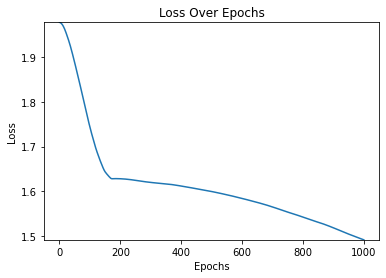

In [11]:
nn.plot_loss()

In [12]:
accuracy = nn.score(X_test, y_test)
print(accuracy)

0.2281


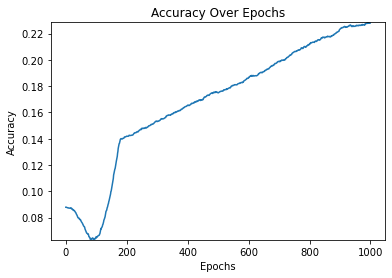

In [13]:
nn.plot_accuracy()

That's all it takes!

To review:
- Step 1: preprocess data using util.preprocess
- Step 2: build the neural network, by instantiating the NN class, and adding layers using add_layer
- Step 3: fit
- Step 4: evaluate

## Tutorial Network Trained on Full Set

We try the architecture tested in tutorial, but trained on the entire dataset

In [14]:
nn_tutorial = NN(X=features, y=target, lr=1e-5, reg_param=1, batch_size=256)
nn_tutorial.add_layer(nodes=100, activation="sigmoid")
nn_tutorial.add_layer(nodes=60, activation="relu")
nn_tutorial.add_layer(nodes=50, activation="sigmoid")
nn_tutorial.add_layer(nodes=10, activation="softmax")

In [66]:
%%time
nn_tutorial.fit(epochs=15, calc_accuracy={"X_test": X_test, "y_test": y_test})

Starting epoch 1/15. Processing: ************
Loss is 0.0141812. Accuracy is 0.1825


Starting epoch 2/15. Processing: ************
Loss is 0.0142222. Accuracy is 0.1777


Starting epoch 3/15. Processing: ************
Loss is 0.0142974. Accuracy is 0.1672


Starting epoch 4/15. Processing: ************
Loss is 0.0144045. Accuracy is 0.1544


Starting epoch 5/15. Processing: ************
Loss is 0.0145284. Accuracy is 0.1488


Starting epoch 6/15. Processing: ************
Loss is 0.0146605. Accuracy is 0.1462


Starting epoch 7/15. Processing: ************
Loss is 0.0148006. Accuracy is 0.1441


Starting epoch 8/15. Processing: ************
Loss is 0.0149232. Accuracy is 0.1462


Starting epoch 9/15. Processing: ************
Loss is 0.0150409. Accuracy is 0.1463


Starting epoch 10/15. Processing: ************
Loss is 0.0151583. Accuracy is 0.1525


Starting epoch 11/15. Processing: ************
Loss is 0.0152731. Accuracy is 0.1564


Starting epoch 12/15. Processing: ************
Loss 

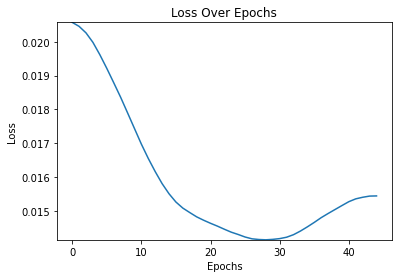

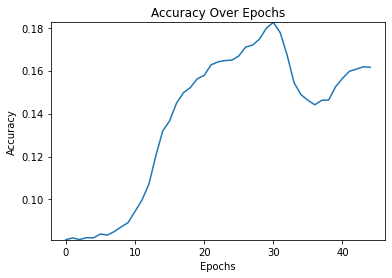

0.1616

In [67]:
nn_tutorial.plot_loss()
nn_tutorial.plot_accuracy()
nn_tutorial.score(X_test, y_test)

## All Sigmoid Hidden Layers

We try the same architecture, but using sigmoid instead of relue for the acitvation of the second hidden layer

In [17]:
nn_3_sigmoid = NN(X=features, y=target, lr=1e-5, reg_param=1, batch_size=256)
nn_3_sigmoid.add_layer(nodes=100, activation="sigmoid")
nn_3_sigmoid.add_layer(nodes=60, activation="sigmoid")
nn_3_sigmoid.add_layer(nodes=50, activation="sigmoid")
nn_3_sigmoid.add_layer(nodes=10, activation="softmax")

In [50]:
%%time
nn_3_sigmoid.fit(epochs=15, calc_accuracy={"X_test": X_test, "y_test": y_test})

Starting epoch 1/15. Processing: ************
Loss is 0.0129565. Accuracy is 0.4376


Starting epoch 2/15. Processing: ************
Loss is 0.0129422. Accuracy is 0.3921


Starting epoch 3/15. Processing: ************
Loss is 0.0129341. Accuracy is 0.3428


Starting epoch 4/15. Processing: ************
Loss is 0.0129335. Accuracy is 0.2909


Starting epoch 5/15. Processing: ************
Loss is 0.0129338. Accuracy is 0.2482


Starting epoch 6/15. Processing: ************
Loss is 0.0129404. Accuracy is 0.2155


Starting epoch 7/15. Processing: ************
Loss is 0.0129564. Accuracy is 0.202


Starting epoch 8/15. Processing: ************
Loss is 0.0129724. Accuracy is 0.1936


Starting epoch 9/15. Processing: ************
Loss is 0.0129858. Accuracy is 0.1872


Starting epoch 10/15. Processing: ************
Loss is 0.0129974. Accuracy is 0.1833


Starting epoch 11/15. Processing: ************
Loss is 0.0130035. Accuracy is 0.182


Starting epoch 12/15. Processing: ************
Loss is

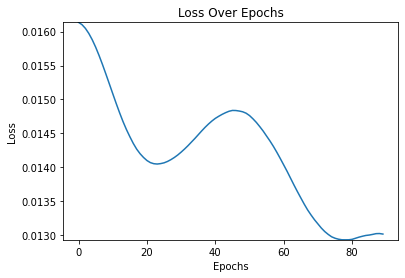

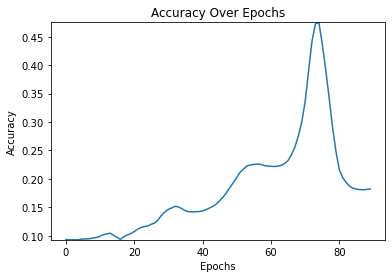

0.1822

In [51]:
nn_3_sigmoid.plot_loss()
nn_3_sigmoid.plot_accuracy()
nn_3_sigmoid.score(X_test, y_test)

## Two Relu/ One Sigmoid Hidden Layers

In [20]:
nn_2_relu_1_sig = NN(X=features, y=target, lr=1e-100, reg_param=1, batch_size=256)
nn_2_relu_1_sig.add_layer(nodes=100, activation="relu")
nn_2_relu_1_sig.add_layer(nodes=60, activation="relu")
nn_2_relu_1_sig.add_layer(nodes=50, activation="sigmoid")
nn_2_relu_1_sig.add_layer(nodes=10, activation="softmax")

In [21]:
%%time
nn_2_relu_1_sig.fit(epochs=15, calc_accuracy={"X_test": X_test, "y_test": y_test})

Starting epoch 1/15. Processing: ************
Loss is 0.0211812. Accuracy is 0.1067


Starting epoch 2/15. Processing: ************
Loss is 0.0211812. Accuracy is 0.1067


Starting epoch 3/15. Processing: ************
Loss is 0.0211812. Accuracy is 0.1067


Starting epoch 4/15. Processing: ************
Loss is 0.0211812. Accuracy is 0.1067


Starting epoch 5/15. Processing: ************
Loss is 0.0211812. Accuracy is 0.1067


Starting epoch 6/15. Processing: ************
Loss is 0.0211812. Accuracy is 0.1067


Starting epoch 7/15. Processing: ************
Loss is 0.0211812. Accuracy is 0.1067


Starting epoch 8/15. Processing: ************
Loss is 0.0211812. Accuracy is 0.1067


Starting epoch 9/15. Processing: ************
Loss is 0.0211812. Accuracy is 0.1067


Starting epoch 10/15. Processing: ************
Loss is 0.0211812. Accuracy is 0.1067


Starting epoch 11/15. Processing: ************
Loss is 0.0211812. Accuracy is 0.1067


Starting epoch 12/15. Processing: ************
Loss 

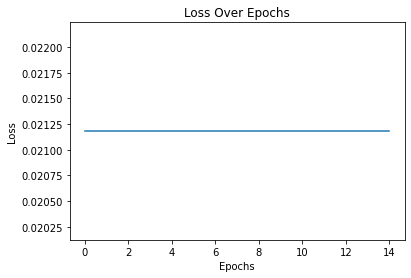

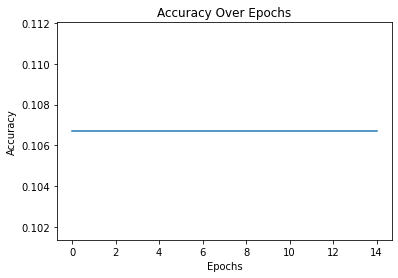

0.1067

In [22]:
nn_2_relu_1_sig.plot_loss()
nn_2_relu_1_sig.plot_accuracy()
nn_2_relu_1_sig.score(X_test, y_test)

## All Sigmoid 5 Hidden Layers

In [23]:
nn_5_sigmoid = NN(X=features, y=target, lr=1e-5, reg_param=1, batch_size=256)
nn_5_sigmoid.add_layer(nodes=100, activation="sigmoid")
nn_5_sigmoid.add_layer(nodes=60, activation="sigmoid")
nn_5_sigmoid.add_layer(nodes=50, activation="sigmoid")
nn_5_sigmoid.add_layer(nodes=40, activation="sigmoid")
nn_5_sigmoid.add_layer(nodes=30, activation="sigmoid")
nn_5_sigmoid.add_layer(nodes=10, activation="softmax")

In [52]:
nn_5_sigmoid.fit(epochs=15, calc_accuracy={"X_test": X_test, "y_test": y_test})

Starting epoch 1/15. Processing: ************
Loss is 0.0148498. Accuracy is 0.1037


Starting epoch 2/15. Processing: ************
Loss is 0.0149079. Accuracy is 0.1028


Starting epoch 3/15. Processing: ************
Loss is 0.0149659. Accuracy is 0.1028


Starting epoch 4/15. Processing: ************
Loss is 0.0150237. Accuracy is 0.1028


Starting epoch 5/15. Processing: ************
Loss is 0.0150813. Accuracy is 0.1028


Starting epoch 6/15. Processing: ************
Loss is 0.0151387. Accuracy is 0.1028


Starting epoch 7/15. Processing: ************
Loss is 0.0151958. Accuracy is 0.1028


Starting epoch 8/15. Processing: ************
Loss is 0.0152528. Accuracy is 0.1028


Starting epoch 9/15. Processing: ************
Loss is 0.0153098. Accuracy is 0.0993


Starting epoch 10/15. Processing: ************
Loss is 0.0153667. Accuracy is 0.1034


Starting epoch 11/15. Processing: ************
Loss is 0.0154237. Accuracy is 0.0962


Starting epoch 12/15. Processing: ************
Loss 

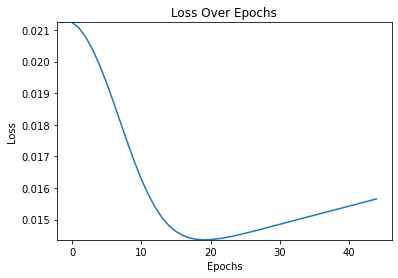

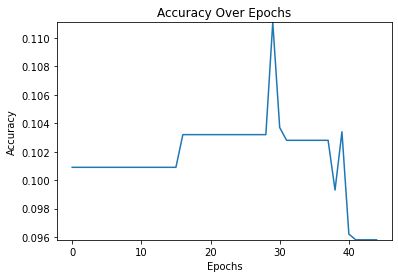

0.0958

In [53]:
nn_5_sigmoid.plot_loss()
nn_5_sigmoid.plot_accuracy()
nn_5_sigmoid.score(X_test, y_test)

## Two Sigmoid Hidden Layers

In [26]:
nn_2_sigmoid = NN(X=features, y=target, lr=1e-5, reg_param=1, batch_size=256)
nn_2_sigmoid.add_layer(nodes=100, activation="sigmoid")
nn_2_sigmoid.add_layer(nodes=60, activation="sigmoid")
nn_2_sigmoid.add_layer(nodes=10, activation="softmax")

In [62]:
%%time
nn_2_sigmoid.fit(epochs=15, calc_accuracy={"X_test": X_test, "y_test": y_test})

Starting epoch 1/15. Processing: ************
Loss is 0.008928. Accuracy is 0.5596


Starting epoch 2/15. Processing: ************
Loss is 0.0089729. Accuracy is 0.5422


Starting epoch 3/15. Processing: ************
Loss is 0.0090418. Accuracy is 0.5262


Starting epoch 4/15. Processing: ************
Loss is 0.0091255. Accuracy is 0.5111


Starting epoch 5/15. Processing: ************
Loss is 0.0092212. Accuracy is 0.4969


Starting epoch 6/15. Processing: ************
Loss is 0.0093382. Accuracy is 0.4833


Starting epoch 7/15. Processing: ************
Loss is 0.0094695. Accuracy is 0.4706


Starting epoch 8/15. Processing: ************
Loss is 0.009575. Accuracy is 0.4597


Starting epoch 9/15. Processing: ************
Loss is 0.0097241. Accuracy is 0.4499


Starting epoch 10/15. Processing: ************
Loss is 0.0098446. Accuracy is 0.4403


Starting epoch 11/15. Processing: ************
Loss is 0.0099548. Accuracy is 0.4333


Starting epoch 12/15. Processing: ************
Loss is

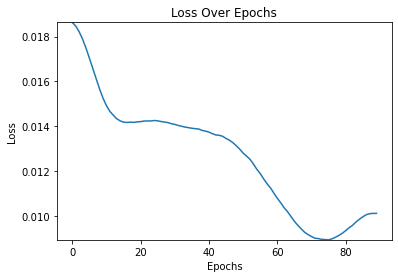

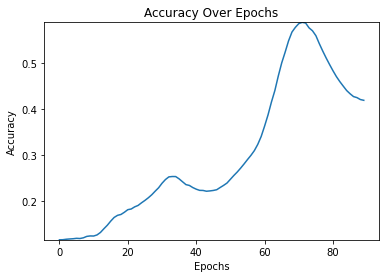

0.4191

In [63]:
nn_2_sigmoid.plot_loss()
nn_2_sigmoid.plot_accuracy()
nn_2_sigmoid.score(X_test, y_test)

## One Sigmoid Hidden Layer

In [29]:
nn_1_sigmoid = NN(X=features, y=target, lr=1e-5, reg_param=1, batch_size=256)
nn_1_sigmoid.add_layer(nodes=100, activation="sigmoid")
nn_1_sigmoid.add_layer(nodes=10, activation="softmax")

In [72]:
nn_1_sigmoid.fit(epochs=15, calc_accuracy={"X_test": X_test, "y_test": y_test})

Starting epoch 1/15. Processing: ************
Loss is 0.0065815. Accuracy is 0.6296


Starting epoch 2/15. Processing: ************
Loss is 0.0065861. Accuracy is 0.6281


Starting epoch 3/15. Processing: ************
Loss is 0.0067221. Accuracy is 0.6309


Starting epoch 4/15. Processing: ************
Loss is 0.0067834. Accuracy is 0.6286


Starting epoch 5/15. Processing: ************
Loss is 0.0068373. Accuracy is 0.6265


Starting epoch 6/15. Processing: ************
Loss is 0.0068469. Accuracy is 0.6267


Starting epoch 7/15. Processing: ************
Loss is 0.0069317. Accuracy is 0.623


Starting epoch 8/15. Processing: ************
Loss is 0.0070083. Accuracy is 0.6217


Starting epoch 9/15. Processing: ************
Loss is 0.0070907. Accuracy is 0.6196


Starting epoch 10/15. Processing: ************
Loss is 0.0071429. Accuracy is 0.6178


Starting epoch 11/15. Processing: ************
Loss is 0.0071798. Accuracy is 0.6132


Starting epoch 12/15. Processing: ************
Loss i

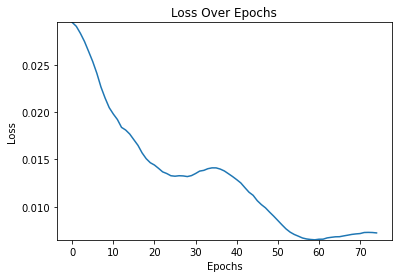

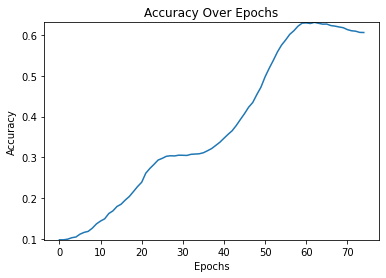

0.606

In [73]:
nn_1_sigmoid.plot_loss()
nn_1_sigmoid.plot_accuracy()
nn_1_sigmoid.score(X_test, y_test)

## Wider One Sigmoid Layer

We also add learning rate scaler to automatically adjust learning rate during training.

In [32]:
nn_1_wide_sigmoid = NN(X=features, y=target, lr=1e-5, reg_param=1, batch_size=256, lr_scaling=0.8)
nn_1_wide_sigmoid.add_layer(nodes=800, activation="sigmoid")
nn_1_wide_sigmoid.add_layer(nodes=10, activation="softmax")

In [74]:
nn_1_wide_sigmoid.fit(epochs=15, calc_accuracy={"X_test": X_test, "y_test": y_test})

Starting epoch 1/15. Processing: ************
Loss is nan. Accuracy is 0.7826


Starting epoch 2/15. Processing: ************
Loss is nan. Accuracy is 0.7824


Starting epoch 3/15. Processing: ************
Loss is nan. Accuracy is 0.7762


Starting epoch 4/15. Processing: ************
Loss is nan. Accuracy is 0.7705


Starting epoch 5/15. Processing: ************
Loss is nan. Accuracy is 0.7708


Starting epoch 6/15. Processing: ************
Loss is nan. Accuracy is 0.7725


Starting epoch 7/15. Processing: ************
Loss is nan. Accuracy is 0.7774


Starting epoch 8/15. Processing: ************
Loss is nan. Accuracy is 0.7812


Starting epoch 9/15. Processing: ************
Loss is nan. Accuracy is 0.7912


Starting epoch 10/15. Processing: ************
Loss is nan. Accuracy is 0.799


Starting epoch 11/15. Processing: ************
Loss is nan. Accuracy is 0.8068


Starting epoch 12/15. Processing: ************
Loss is nan. Accuracy is 0.8169


Starting epoch 13/15. Processing: ****

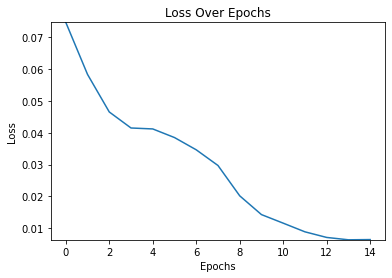

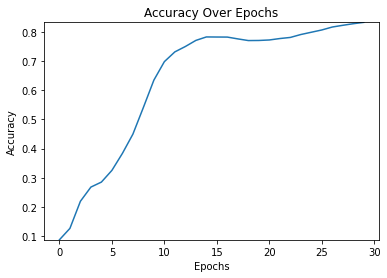

0.8329

In [75]:
nn_1_wide_sigmoid.plot_loss()
nn_1_wide_sigmoid.plot_accuracy()
nn_1_wide_sigmoid.score(X_test, y_test)

## SGD Wider One Sigmoid Layer

In [35]:
nn_1_wide_sigmoid_sgd = NN(X=features, y=target, lr=1e-5, reg_param=1, batch_size=1, lr_scaling=0.8)
nn_1_wide_sigmoid_sgd.add_layer(nodes=800, activation="sigmoid")
nn_1_wide_sigmoid_sgd.add_layer(nodes=10, activation="softmax")

In [36]:
nn_1_wide_sigmoid_sgd.fit(epochs=15, calc_accuracy={"X_test": X_test, "y_test": y_test})

Starting epoch 1/15. Processing: ************************************************************
Loss is 0.0002691. Accuracy is 0.7113


Starting epoch 2/15. Processing: ************************************************************
Loss is 0.0. Accuracy is 0.8213


Starting epoch 3/15. Processing: ************************************************************
Loss is 0.0. Accuracy is 0.8562


Beginning to diverge... scaling learning rate by from 1e-05, by 0.8, to 8.000000000000001e-06
Starting epoch 4/15. Processing: ************************************************************
Loss is 1e-07. Accuracy is 0.8463


Beginning to diverge... scaling learning rate by from 8.000000000000001e-06, by 0.8, to 6.400000000000001e-06
Starting epoch 5/15. Processing: ************************************************************
Loss is 4e-07. Accuracy is 0.8869


Beginning to diverge... scaling learning rate by from 6.400000000000001e-06, by 0.8, to 5.120000000000002e-06
Starting epoch 6/15. Processing: ***

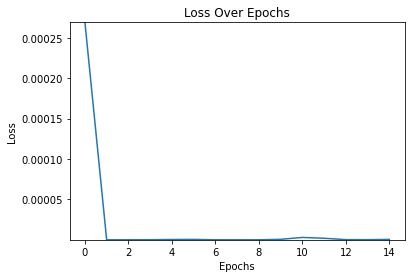

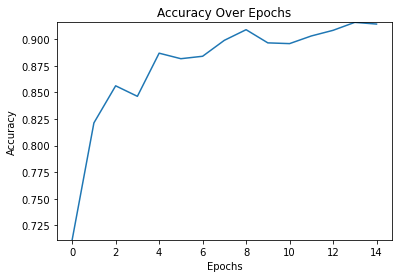

0.9143

In [37]:
nn_1_wide_sigmoid_sgd.plot_loss()
nn_1_wide_sigmoid_sgd.plot_accuracy()
nn_1_wide_sigmoid_sgd.score(X_test, y_test)